# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip

#### Import GWAS data

 https://docs.google.com/spreadsheets/d/1kvPoupSzsSFBNSztMzl04xMoSC3Kcx3CrjVf4yBmESU/edit?gid=178908679#gid=178908679 (row 7217)
 
 50_irnt.gwas.imputed_v3.both_sexes.tsv.bgz' 

#### Import Gene Annotation File

https://github.com/hakha-most/gwas_eqtl/blob/master/gene_annotations/genes.protein_coding.v39.gtf

In [2]:
# Local path to GTF file
gtf_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Data/genes.protein_coding.v39.gtf'
# Path to GWAS file
gwas_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Data/50_irnt.gwas.imputed_v3.both_sexes.tsv.bgz'
# Path to S Het file
s_het_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Data/s_het_info.xlsx'

# Load the GTF file into a pandas DataFrame and use the first row as headers
gtf_df = pd.read_csv(gtf_file_path, sep='\t', header=0)
gtf_df.sort_values('start')

s_het_info = pd.read_excel(s_het_file_path)

#how many closest genes we want to find
n_closest = 5

# Data Cleaning

#### Drop Genes without s_het values

In [3]:
# Ensure both columns are in the same format (optional but recommended)
s_het_info['ensg'] = s_het_info['ensg'].str.strip().str.lower()
gtf_df['GeneSymbol'] = gtf_df['GeneSymbol'].str.strip().str.lower()

# Filter gtf_df to keep only rows with GeneSymbol values that are in s_het_info['ensg']
gtf_df_filtered = gtf_df[gtf_df['GeneSymbol'].isin(s_het_info['ensg'])]

# Optionally, replace gtf_df with the filtered DataFrame
gtf_df = gtf_df_filtered

# Display the size of the filtered DataFrame and its contents
print(f"Filtered gtf_df size: {gtf_df.shape}")
# gtf_df  # Display the first few rows of the filtered DataFrame

Filtered gtf_df size: (17657, 10)


#### Convert chr to int

In [4]:
gtf_df['chr'] = gtf_df['chr'].str[3:].astype(int)
gtf_df['start'] = gtf_df['start'].astype(int)

In [5]:
# Open and read the compressed .bgz file using gzip
with gzip.open(gwas_file_path, 'rt') as f:
    # Load the file into a pandas DataFrame
    gwas_df = pd.read_csv(f, sep='\t')

In [6]:
gwas_df.shape

(13791467, 11)

#### Find Variant Chromosome and Position

In [7]:
gwas_df[['chr', 'pos', 'ref', 'alt']] = gwas_df['variant'].str.split(':', expand=True)
gwas_df.head(1)

,variant,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,pval,chr,pos,ref,alt
0,1:15791:C:T,T,5.440760e-09,True,360388,0.003922,0.003474,18.0499,178.468,0.101138,0.919441,1,15791,C,T


In [8]:
gwas_df = gwas_df[gwas_df['chr'] != 'X']
gwas_df['chr'] = gwas_df['chr'].astype(int)
gwas_df['pos'] = gwas_df['pos'].astype(int)

In [9]:
# gwas_df.groupby('chr')['pos'].agg({'min','max'}).reset_index()

It appears that position resets on each chromosome 

# Join to Find 5 Nearest Genes 

In [10]:
def repeated_forward_merge(gwas_df, gtf_df, num_merges= n_closest):
    # Initial sorting of key columns for the first merge
    gwas_sorted = gwas_df[['variant', 'pval', 'chr', 'pos']].sort_values('pos')
    gtf_sorted = gtf_df[['chr', 'start', 'GeneSymbol', 'gene']].sort_values('start')

    # Ensure both 'start' columns are of the same type (convert to float to handle NaNs)
    gtf_sorted['start'] = gtf_sorted['start'].astype(float)
    gwas_sorted['pos'] = gwas_sorted['pos'].astype(float)

    # First merge_asof
    merged_df = pd.merge_asof(
        gwas_sorted, 
        gtf_sorted, 
        by='chr', 
        left_on='pos', 
        right_on='start', 
        direction='forward',
        suffixes=('', '_f1')  # First set of suffixes
    )

    # Replace NaN values in 'start' column and rename for subsequent merges
    merged_df['start'] = merged_df['start'].fillna(np.inf)
    merged_df = merged_df.rename(columns={'start': 'start_f1', 'GeneSymbol': 'GeneSymbol_f1', 'gene': 'gene_f1'})
    merged_df = merged_df.sort_values('start_f1')

    # Iterative forward merges
    for i in range(2, num_merges + 1):
        # Ensure both columns are of the same type
        merged_df[f'start_f{i-1}'] = merged_df[f'start_f{i-1}'].astype(float)
        gtf_sorted['start'] = gtf_sorted['start'].astype(float)

        # Perform the next forward merge
        merged_df = pd.merge_asof(
            merged_df, 
            gtf_sorted, 
            by='chr', 
            left_on=f'start_f{i-1}', 
            right_on='start', 
            direction='forward',
            allow_exact_matches=False,
            suffixes=(f'_f{i-1}', f'_f{i}')
        )

        # Replace NaN values in the new 'start' column and rename for next iteration
        merged_df['start'] = merged_df['start'].fillna(np.inf)
        merged_df = merged_df.rename(columns={
            'start': f'start_f{i}', 
            'GeneSymbol': f'GeneSymbol_f{i}', 
            'gene': f'gene_f{i}'
        })
        merged_df = merged_df.sort_values(f'start_f{i}')

    # After the last merge, replace all np.inf values back to NaN
    for i in range(1, num_merges + 1):
        merged_df[f'start_f{i}'] = merged_df[f'start_f{i}'].replace(np.inf, np.nan)
    
    return merged_df

f_final = repeated_forward_merge(gwas_df, gtf_df, num_merges=n_closest)

In [11]:
# Adjusted function to ensure all negative infinity values are replaced with NaN in the final result
def repeated_backward_merge_with_nan(gwas_df, gtf_df, num_merges=n_closest):
    # Initial sorting of key columns for the first merge
    gwas_sorted = gwas_df.sort_values('pos')
    gtf_sorted = gtf_df[['chr', 'start', 'GeneSymbol', 'gene']].sort_values('start')

    # Ensure both 'start' columns are of the same type (convert to float to handle NaNs)
    gtf_sorted['start'] = gtf_sorted['start'].astype(float)
    gwas_sorted['pos'] = gwas_sorted['pos'].astype(float)

    # First backward merge_asof
    merged_df = pd.merge_asof(
        gwas_sorted, 
        gtf_sorted, 
        by='chr', 
        left_on='pos', 
        right_on='start', 
        direction='backward',
        suffixes=('', '_b1')  # First set of suffixes
    )

    # Replace NaN values in 'start' column and rename for subsequent merges
    merged_df['start'] = merged_df['start'].fillna(-np.inf)
    merged_df = merged_df.rename(columns={'start': 'start_b1', 'GeneSymbol': 'GeneSymbol_b1', 'gene': 'gene_b1'})
    merged_df = merged_df.sort_values('start_b1')

    # Iterative backward merges
    for i in range(2, num_merges + 1):
        # Ensure both columns are of the same type
        merged_df[f'start_b{i-1}'] = merged_df[f'start_b{i-1}'].astype(float)
        gtf_sorted['start'] = gtf_sorted['start'].astype(float)

        # Perform the next backward merge
        merged_df = pd.merge_asof(
            merged_df, 
            gtf_sorted, 
            by='chr', 
            left_on=f'start_b{i-1}', 
            right_on='start', 
            direction='backward',
            allow_exact_matches=False,
            suffixes=(f'_b{i-1}', f'_b{i}')
        )

        # Replace NaN values in the new 'start' column and rename for next iteration
        merged_df['start'] = merged_df['start'].fillna(-np.inf)
        merged_df = merged_df.rename(columns={
            'start': f'start_b{i}', 
            'GeneSymbol': f'GeneSymbol_b{i}', 
            'gene': f'gene_b{i}'
        })
        merged_df = merged_df.sort_values(f'start_b{i}')

    # After the last merge, replace all -np.inf values back to NaN
    for i in range(1, num_merges + 1):
        merged_df[f'start_b{i}'] = merged_df[f'start_b{i}'].replace(-np.inf, np.nan)
    
    return merged_df

# Example usage:
f_b_final = repeated_backward_merge_with_nan(f_final, gtf_df, num_merges=n_closest)

In [12]:
# Function to calculate differences between pos and all forward and backward start columns
def calculate_differences(df, num_merges=n_closest):
    # Calculate the difference between pos and start_f1, start_f2, ..., start_fx for forward merges
    for i in range(1, num_merges + 1):
        df[f'diff_f{i}'] = np.abs(df[f'start_f{i}'] - df['pos'])
        df[f'diff_f{i}'] = np.where(df[f'diff_f{i}'] == 0, 1, df[f'diff_f{i}'])  # Ensure minimum value is 1

    # Calculate the difference between pos and start_b1, start_b2, ..., start_bx for backward merges
    for i in range(1, num_merges + 1):
        df[f'diff_b{i}'] = np.abs(df[f'start_b{i}'] - df['pos'])
        df[f'diff_b{i}'] = np.where(df[f'diff_b{i}'] == 0, 1, df[f'diff_b{i}'])  # Ensure minimum value is 1
    
    return df

f_b_final_with_differences = calculate_differences(f_b_final, num_merges=n_closest)

In [13]:
f_b_final_with_differences = f_b_final_with_differences.reset_index(drop=True)

In [14]:
def vectorized_reorder_rename_columns(df):
    # Get all diff columns (assuming 5 forward and 5 backward)
    diff_columns = [col for col in df.columns if col.startswith('diff_')]

    # Create a DataFrame of just the diff values
    diff_df = df[diff_columns]
    
    # Get the indices of the 5 smallest diffs for each row
    diff_order = diff_df.values.argsort(axis=1)[:, :n_closest]
    
    # Function to reorder and rename a set of columns
    def reorder_and_rename(prefix):
        cols = [col.replace('diff_', prefix) for col in diff_columns]
        values = df[cols].values
        reordered = np.take_along_axis(values, diff_order, axis=1)
        return pd.DataFrame(reordered, columns=[f'{prefix[:-1]}_{i}' for i in range(1, n_closest+1)], index=df.index)

    # Reorder and rename for each set of columns
    new_dfs = [reorder_and_rename(prefix) for prefix in ['diff_', 'gene_', 'start_', 'GeneSymbol_']]
    
    # Create direction columns
    ordered_diff_columns = np.array(diff_columns)[diff_order]
    #something wrong here
    #directions = np.where(np.char.find(ordered_diff_columns.astype(str), 'f') != -1, 'f', 'b')
    directions = np.where(
    np.char.find(ordered_diff_columns.astype(str), 'diff_f') != -1,  # Check for 'diff_f' in the column names
    'f',  # Set direction as 'f'
    'b'   # Otherwise, set direction as 'b'
)
    direction_df = pd.DataFrame(directions, columns=[f'direction_{i}' for i in range(1, n_closest+1)], index=df.index)
    new_dfs.append(direction_df)
    
    # Combine all new DataFrames
    result_df = pd.concat(new_dfs, axis=1)
    
    # Add any other columns that weren't part of the reordering
    other_columns = [col for col in df.columns if not any(col.startswith(prefix) for prefix in ['diff_', 'gene_', 'start_', 'GeneSymbol_'])]
    result_df = pd.concat([result_df, df[other_columns]], axis=1)
    
    # Reorder columns to group related information together
    column_order = (
        [f'{prefix}_{i}' for i in range(1, n_closest+1) for prefix in ['diff', 'gene', 'start', 'GeneSymbol', 'direction']] +
        other_columns
    )
    
    return result_df[column_order]

f_b_final_with_differences = vectorized_reorder_rename_columns(f_b_final_with_differences)

In [15]:
f_b_final_with_differences

,diff_1,gene_1,start_1,GeneSymbol_1,direction_1,diff_2,gene_2,start_2,GeneSymbol_2,direction_2,...,direction_4,diff_5,gene_5,start_5,GeneSymbol_5,direction_5,variant,pval,chr,pos
0,5508.0,DOC2B,5810.0,ensg00000272636,f,61878.0,RPH3AL,62180.0,ensg00000181031,f,...,f,411441.0,VPS53,411743.0,ensg00000141252,f,17:302:T:TA,0.281579,17,302.0
1,306260.0,CHL1,238446.0,ensg00000134121,b,589636.0,CNTN6,1134342.0,ensg00000134115,f,...,f,2623911.0,TRNT1,3168617.0,ensg00000072756,f,3:544706:CT:C,0.808601,3,544706.0
2,23977.0,CNTN6,1134342.0,ensg00000134115,f,871919.0,CHL1,238446.0,ensg00000134121,b,...,f,2058252.0,TRNT1,3168617.0,ensg00000072756,f,3:1110365:CCTGATTTCCTG:C,0.331704,3,1110365.0
3,299846.0,CNTN6,1134342.0,ensg00000134115,f,596050.0,CHL1,238446.0,ensg00000134121,b,...,f,2334121.0,TRNT1,3168617.0,ensg00000072756,f,3:834496:T:TA,0.231408,3,834496.0
4,79007.0,CNTN6,1134342.0,ensg00000134115,f,816889.0,CHL1,238446.0,ensg00000134121,b,...,f,2113282.0,TRNT1,3168617.0,ensg00000072756,f,3:1055335:C:T,0.535970,3,1055335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,5428.0,PGBD2,249200395.0,ensg00000185220,b,61618.0,ZNF692,249144205.0,ensg00000171163,b,...,b,361200.0,OR14I1,248844623.0,ensg00000189181,b,1:249205823:G:A,0.918853,1,249205823.0
13364299,5411.0,PGBD2,249200395.0,ensg00000185220,b,61601.0,ZNF692,249144205.0,ensg00000171163,b,...,b,361183.0,OR14I1,248844623.0,ensg00000189181,b,1:249205806:T:C,0.989577,1,249205806.0
13364300,5379.0,PGBD2,249200395.0,ensg00000185220,b,61569.0,ZNF692,249144205.0,ensg00000171163,b,...,b,361151.0,OR14I1,248844623.0,ensg00000189181,b,1:249205774:T:C,0.767464,1,249205774.0
13364301,4851.0,PGBD2,249200395.0,ensg00000185220,b,61041.0,ZNF692,249144205.0,ensg00000171163,b,...,b,360623.0,OR14I1,248844623.0,ensg00000189181,b,1:249205246:T:A,0.937160,1,249205246.0


In [16]:
f_b_final_with_differences.columns

Index(['diff_1', 'gene_1', 'start_1', 'GeneSymbol_1', 'direction_1', 'diff_2',
       'gene_2', 'start_2', 'GeneSymbol_2', 'direction_2', 'diff_3', 'gene_3',
       'start_3', 'GeneSymbol_3', 'direction_3', 'diff_4', 'gene_4', 'start_4',
       'GeneSymbol_4', 'direction_4', 'diff_5', 'gene_5', 'start_5',
       'GeneSymbol_5', 'direction_5', 'variant', 'pval', 'chr', 'pos'],
      dtype='object')

In [17]:
f_b_final_with_differences.isna().sum()

diff_1             0
gene_1             0
start_1            0
GeneSymbol_1       0
direction_1        0
diff_2             0
gene_2             0
start_2            0
GeneSymbol_2       0
direction_2        0
diff_3             0
gene_3             0
start_3            0
GeneSymbol_3       0
direction_3        0
diff_4             0
gene_4             0
start_4            0
GeneSymbol_4       0
direction_4        0
diff_5             0
gene_5             0
start_5            0
GeneSymbol_5       0
direction_5        0
variant            0
pval            1665
chr                0
pos                0
dtype: int64

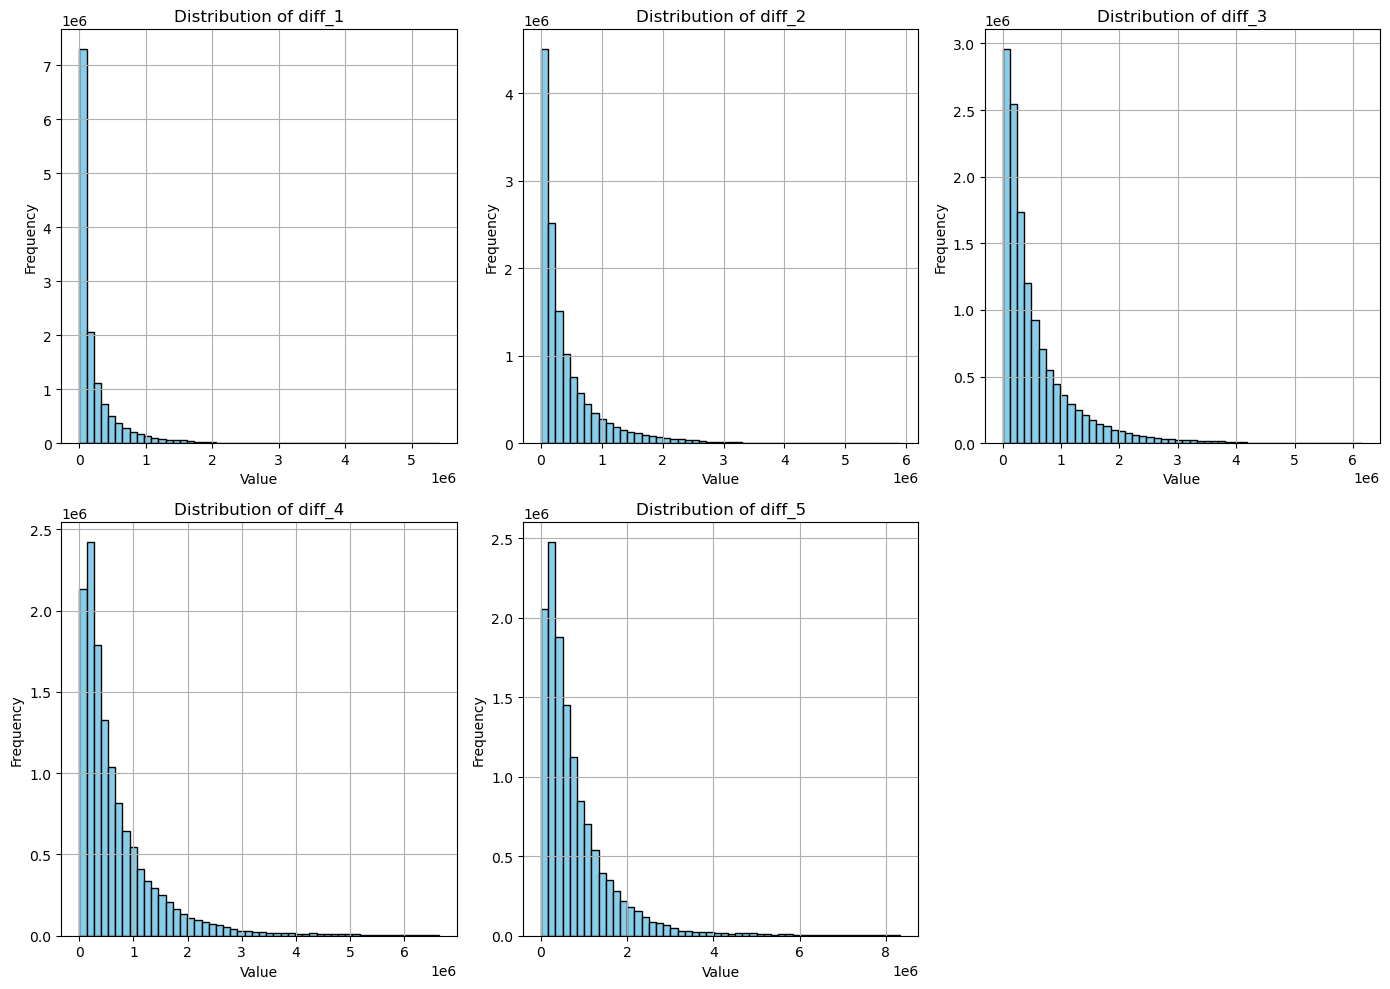

In [18]:
# Plot histograms for each difference column
def plot_histograms(df, columns):
    plt.figure(figsize=(14, 10))
    
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i+1)  # Create a subplot for each column
        df[col].hist(bins=50, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Define the columns to plot
columns_to_plot = ['diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_5']

# Call the function to plot histograms
plot_histograms(f_b_final_with_differences, columns_to_plot)


# Join With s_het data

In [19]:
s_het_info.isna().sum()

ensg               0
hgnc               0
chrom              0
obs_lof          371
exp_lof          371
prior_mean         0
post_mean          0
post_lower_95      0
post_upper_95      0
dtype: int64

In [20]:
# Function to perform the merge for all forward and backward GeneSymbols and rename the 'post_mean' columns
def merge_s_het_info_with_all(f_b_final_with_differences, s_het_info, num_merges):
    # Rename 'ensg' column in s_het_info to match the GeneSymbol columns in f_b_final_with_differences
    s_het_info = s_het_info.rename(columns={'ensg': 'GeneSymbol'})

    # Iterate over both forward and backward gene symbols
    for i in range(1, num_merges + 1):
        # Forward merge for each GeneSymbol_f
        f_b_final_with_differences = pd.merge(
            f_b_final_with_differences, 
            s_het_info[['GeneSymbol', 'post_mean']], 
            left_on=f'GeneSymbol_{i}', 
            right_on='GeneSymbol', 
            how='left',
            suffixes=('', f'_{i}')
        )
        
        # Rename the post_mean column to indicate the forward direction
        f_b_final_with_differences = f_b_final_with_differences.rename(
            columns={'post_mean': f's_het_post_{i}'}
        )
        
        # Drop the duplicated 'GeneSymbol' column created during the merge
        f_b_final_with_differences = f_b_final_with_differences.drop(columns='GeneSymbol', errors='ignore')

    return f_b_final_with_differences

# Example usage:
f_b_final_merged_s_het = merge_s_het_info_with_all(f_b_final_with_differences, s_het_info, num_merges=n_closest)

In [21]:
f_b_final_merged_s_het.columns

Index(['diff_1', 'gene_1', 'start_1', 'GeneSymbol_1', 'direction_1', 'diff_2',
       'gene_2', 'start_2', 'GeneSymbol_2', 'direction_2', 'diff_3', 'gene_3',
       'start_3', 'GeneSymbol_3', 'direction_3', 'diff_4', 'gene_4', 'start_4',
       'GeneSymbol_4', 'direction_4', 'diff_5', 'gene_5', 'start_5',
       'GeneSymbol_5', 'direction_5', 'variant', 'pval', 'chr', 'pos',
       's_het_post_1', 's_het_post_2', 's_het_post_3', 's_het_post_4',
       's_het_post_5'],
      dtype='object')

In [22]:
f_b_final_merged_s_het

,diff_1,gene_1,start_1,GeneSymbol_1,direction_1,diff_2,gene_2,start_2,GeneSymbol_2,direction_2,...,direction_5,variant,pval,chr,pos,s_het_post_1,s_het_post_2,s_het_post_3,s_het_post_4,s_het_post_5
0,5508.0,DOC2B,5810.0,ensg00000272636,f,61878.0,RPH3AL,62180.0,ensg00000181031,f,...,f,17:302:T:TA,0.281579,17,302.0,0.014912,0.001230,0.001599,0.020787,0.021360
1,306260.0,CHL1,238446.0,ensg00000134121,b,589636.0,CNTN6,1134342.0,ensg00000134115,f,...,f,3:544706:CT:C,0.808601,3,544706.0,0.014032,0.000932,0.039412,0.001317,0.001015
2,23977.0,CNTN6,1134342.0,ensg00000134115,f,871919.0,CHL1,238446.0,ensg00000134121,b,...,f,3:1110365:CCTGATTTCCTG:C,0.331704,3,1110365.0,0.000932,0.014032,0.039412,0.001317,0.001015
3,299846.0,CNTN6,1134342.0,ensg00000134115,f,596050.0,CHL1,238446.0,ensg00000134121,b,...,f,3:834496:T:TA,0.231408,3,834496.0,0.000932,0.014032,0.039412,0.001317,0.001015
4,79007.0,CNTN6,1134342.0,ensg00000134115,f,816889.0,CHL1,238446.0,ensg00000134121,b,...,f,3:1055335:C:T,0.535970,3,1055335.0,0.000932,0.014032,0.039412,0.001317,0.001015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,5428.0,PGBD2,249200395.0,ensg00000185220,b,61618.0,ZNF692,249144205.0,ensg00000171163,b,...,b,1:249205823:G:A,0.918853,1,249205823.0,0.001772,0.006796,0.003478,0.042778,0.001540
13364299,5411.0,PGBD2,249200395.0,ensg00000185220,b,61601.0,ZNF692,249144205.0,ensg00000171163,b,...,b,1:249205806:T:C,0.989577,1,249205806.0,0.001772,0.006796,0.003478,0.042778,0.001540
13364300,5379.0,PGBD2,249200395.0,ensg00000185220,b,61569.0,ZNF692,249144205.0,ensg00000171163,b,...,b,1:249205774:T:C,0.767464,1,249205774.0,0.001772,0.006796,0.003478,0.042778,0.001540
13364301,4851.0,PGBD2,249200395.0,ensg00000185220,b,61041.0,ZNF692,249144205.0,ensg00000171163,b,...,b,1:249205246:T:A,0.937160,1,249205246.0,0.001772,0.006796,0.003478,0.042778,0.001540


In [23]:
f_b_final_merged_s_het.isna().sum()

diff_1             0
gene_1             0
start_1            0
GeneSymbol_1       0
direction_1        0
diff_2             0
gene_2             0
start_2            0
GeneSymbol_2       0
direction_2        0
diff_3             0
gene_3             0
start_3            0
GeneSymbol_3       0
direction_3        0
diff_4             0
gene_4             0
start_4            0
GeneSymbol_4       0
direction_4        0
diff_5             0
gene_5             0
start_5            0
GeneSymbol_5       0
direction_5        0
variant            0
pval            1665
chr                0
pos                0
s_het_post_1       0
s_het_post_2       0
s_het_post_3       0
s_het_post_4       0
s_het_post_5       0
dtype: int64

In [24]:
rows_with_na = f_b_final_merged_s_het[f_b_final_merged_s_het.isna().any(axis=1)]

In [25]:
# Function to keep only the distance and s_het measures from the dataframe
def keep_dist_and_s_het_measures(df, num_merges):
    # List to store column names for distance and s_het measures
    columns_to_keep = ['variant', 'chr', 'pos']

    # Loop to collect the diff and s_het_post column names for forward and backward directions
    for i in range(1, num_merges + 1):
        columns_to_keep.append(f'diff_{i}')
#         columns_to_keep.append(f'diff_b{i}')
        columns_to_keep.append(f's_het_post_{i}')
#         columns_to_keep.append(f's_het_post_b{i}')

    # Keep only the relevant columns
    df_filtered = df[columns_to_keep]

    return df_filtered

# Example usage:
filtered_f_b_final = keep_dist_and_s_het_measures(f_b_final_merged_s_het, num_merges=n_closest)

In [26]:
filtered_f_b_final

,variant,chr,pos,diff_1,s_het_post_1,diff_2,s_het_post_2,diff_3,s_het_post_3,diff_4,s_het_post_4,diff_5,s_het_post_5
0,17:302:T:TA,17,302.0,5508.0,0.014912,61878.0,0.001230,259814.0,0.001599,289467.0,0.020787,411441.0,0.021360
1,3:544706:CT:C,3,544706.0,306260.0,0.014032,589636.0,0.000932,1595791.0,0.039412,2563302.0,0.001317,2623911.0,0.001015
2,3:1110365:CCTGATTTCCTG:C,3,1110365.0,23977.0,0.000932,871919.0,0.014032,1030132.0,0.039412,1997643.0,0.001317,2058252.0,0.001015
3,3:834496:T:TA,3,834496.0,299846.0,0.000932,596050.0,0.014032,1306001.0,0.039412,2273512.0,0.001317,2334121.0,0.001015
4,3:1055335:C:T,3,1055335.0,79007.0,0.000932,816889.0,0.014032,1085162.0,0.039412,2052673.0,0.001317,2113282.0,0.001015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,1:249205823:G:A,1,249205823.0,5428.0,0.001772,61618.0,0.006796,73414.0,0.003478,101178.0,0.042778,361200.0,0.001540
13364299,1:249205806:T:C,1,249205806.0,5411.0,0.001772,61601.0,0.006796,73397.0,0.003478,101161.0,0.042778,361183.0,0.001540
13364300,1:249205774:T:C,1,249205774.0,5379.0,0.001772,61569.0,0.006796,73365.0,0.003478,101129.0,0.042778,361151.0,0.001540
13364301,1:249205246:T:A,1,249205246.0,4851.0,0.001772,61041.0,0.006796,72837.0,0.003478,100601.0,0.042778,360623.0,0.001540


#### Change to kilobase

In [27]:
# Assuming weighted_f_b_final is your DataFrame
columns_to_modify = ['diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_5']

# Divide the specified columns by 1000
filtered_f_b_final[columns_to_modify] = filtered_f_b_final[columns_to_modify] / 1000
filtered_f_b_final

/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_51250/2909891625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_f_b_final[columns_to_modify] = filtered_f_b_final[columns_to_modify] / 1000


,variant,chr,pos,diff_1,s_het_post_1,diff_2,s_het_post_2,diff_3,s_het_post_3,diff_4,s_het_post_4,diff_5,s_het_post_5
0,17:302:T:TA,17,302.0,5.508,0.014912,61.878,0.001230,259.814,0.001599,289.467,0.020787,411.441,0.021360
1,3:544706:CT:C,3,544706.0,306.260,0.014032,589.636,0.000932,1595.791,0.039412,2563.302,0.001317,2623.911,0.001015
2,3:1110365:CCTGATTTCCTG:C,3,1110365.0,23.977,0.000932,871.919,0.014032,1030.132,0.039412,1997.643,0.001317,2058.252,0.001015
3,3:834496:T:TA,3,834496.0,299.846,0.000932,596.050,0.014032,1306.001,0.039412,2273.512,0.001317,2334.121,0.001015
4,3:1055335:C:T,3,1055335.0,79.007,0.000932,816.889,0.014032,1085.162,0.039412,2052.673,0.001317,2113.282,0.001015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,1:249205823:G:A,1,249205823.0,5.428,0.001772,61.618,0.006796,73.414,0.003478,101.178,0.042778,361.200,0.001540
13364299,1:249205806:T:C,1,249205806.0,5.411,0.001772,61.601,0.006796,73.397,0.003478,101.161,0.042778,361.183,0.001540
13364300,1:249205774:T:C,1,249205774.0,5.379,0.001772,61.569,0.006796,73.365,0.003478,101.129,0.042778,361.151,0.001540
13364301,1:249205246:T:A,1,249205246.0,4.851,0.001772,61.041,0.006796,72.837,0.003478,100.601,0.042778,360.623,0.001540


In [28]:
filtered_f_b_final.isna().sum()

variant         0
chr             0
pos             0
diff_1          0
s_het_post_1    0
diff_2          0
s_het_post_2    0
diff_3          0
s_het_post_3    0
diff_4          0
s_het_post_4    0
diff_5          0
s_het_post_5    0
dtype: int64

In [29]:
# Function to compute s_het weighted by 1/distance per gene-SNP pair
def compute_weighted_s_het(df, num_merges):
    # Loop to compute the weighted s_het for both forward and backward directions
    for i in range(1, num_merges + 1):
        # Calculate inverse distance for forward and backward directions
        df[f'inv_dist_{i}'] = 1 / df[f'diff_{i}']
        
        # Compute weighted s_het by multiplying s_het by inverse distance
        df[f'weighted_s_het_{i}'] = df[f'inv_dist_{i}'] * df[f's_het_post_{i}']

    return df

# Example usage:
weighted_f_b_final = compute_weighted_s_het(filtered_f_b_final, num_merges=n_closest)

/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_51250/865351455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'inv_dist_{i}'] = 1 / df[f'diff_{i}']
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_51250/865351455.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'weighted_s_het_{i}'] = df[f'inv_dist_{i}'] * df[f's_het_post_{i}']
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_51250/865351455.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [30]:
weighted_f_b_final

,variant,chr,pos,diff_1,s_het_post_1,diff_2,s_het_post_2,diff_3,s_het_post_3,diff_4,...,inv_dist_1,weighted_s_het_1,inv_dist_2,weighted_s_het_2,inv_dist_3,weighted_s_het_3,inv_dist_4,weighted_s_het_4,inv_dist_5,weighted_s_het_5
0,17:302:T:TA,17,302.0,5.508,0.014912,61.878,0.001230,259.814,0.001599,289.467,...,0.181554,0.002707,0.016161,0.000020,0.003849,0.000006,0.003455,7.181060e-05,0.002430,5.191534e-05
1,3:544706:CT:C,3,544706.0,306.260,0.014032,589.636,0.000932,1595.791,0.039412,2563.302,...,0.003265,0.000046,0.001696,0.000002,0.000627,0.000025,0.000390,5.137319e-07,0.000381,3.867624e-07
2,3:1110365:CCTGATTTCCTG:C,3,1110365.0,23.977,0.000932,871.919,0.014032,1030.132,0.039412,1997.643,...,0.041707,0.000039,0.001147,0.000016,0.000971,0.000038,0.000501,6.592019e-07,0.000486,4.930543e-07
3,3:834496:T:TA,3,834496.0,299.846,0.000932,596.050,0.014032,1306.001,0.039412,2273.512,...,0.003335,0.000003,0.001678,0.000024,0.000766,0.000030,0.000440,5.792140e-07,0.000428,4.347804e-07
4,3:1055335:C:T,3,1055335.0,79.007,0.000932,816.889,0.014032,1085.162,0.039412,2052.673,...,0.012657,0.000012,0.001224,0.000017,0.000922,0.000036,0.000487,6.415294e-07,0.000473,4.802151e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,1:249205823:G:A,1,249205823.0,5.428,0.001772,61.618,0.006796,73.414,0.003478,101.178,...,0.184230,0.000326,0.016229,0.000110,0.013621,0.000047,0.009884,4.227965e-04,0.002769,4.262569e-06
13364299,1:249205806:T:C,1,249205806.0,5.411,0.001772,61.601,0.006796,73.397,0.003478,101.161,...,0.184809,0.000327,0.016234,0.000110,0.013625,0.000047,0.009885,4.228675e-04,0.002769,4.262770e-06
13364300,1:249205774:T:C,1,249205774.0,5.379,0.001772,61.569,0.006796,73.365,0.003478,101.129,...,0.185908,0.000329,0.016242,0.000110,0.013630,0.000047,0.009888,4.230013e-04,0.002769,4.263148e-06
13364301,1:249205246:T:A,1,249205246.0,4.851,0.001772,61.041,0.006796,72.837,0.003478,100.601,...,0.206143,0.000365,0.016382,0.000111,0.013729,0.000048,0.009940,4.252214e-04,0.002773,4.269389e-06


In [31]:
weighted_f_b_final.sort_values('diff_1')

,variant,chr,pos,diff_1,s_het_post_1,diff_2,s_het_post_2,diff_3,s_het_post_3,diff_4,...,inv_dist_1,weighted_s_het_1,inv_dist_2,weighted_s_het_2,inv_dist_3,weighted_s_het_3,inv_dist_4,weighted_s_het_4,inv_dist_5,weighted_s_het_5
3960669,9:37800550:C:T,9,37800550.0,0.001,0.106857,41.319,0.002836,46.750,0.000836,78.847,...,1000.000000,106.857000,0.024202,6.862823e-05,0.021390,1.788513e-05,0.012683,0.000501,0.008670,0.000899
3327828,6:31654732:T:A,6,31654732.0,0.001,0.056265,0.001,0.056265,10.271,0.017087,16.788,...,1000.000000,56.265300,1000.000000,5.626530e+01,0.097362,1.663567e-03,0.059566,0.000123,0.050223,0.000079
1352712,20:13765652:G:A,20,13765652.0,0.001,0.003449,64.241,0.001089,70.683,0.018357,210.363,...,1000.000000,3.449460,0.015566,1.694634e-05,0.014148,2.597046e-04,0.004754,0.000180,0.002528,0.000130
12353760,2:170550963:G:A,2,170550963.0,0.001,0.003456,0.035,0.027616,49.028,0.002145,97.480,...,1000.000000,3.455560,28.571429,7.890229e-01,0.020397,4.374194e-05,0.010259,0.000636,0.009082,0.001552
438015,19:3052907:C:T,19,3052907.0,0.001,0.435534,41.453,0.161874,55.270,0.018987,75.371,...,1000.000000,435.534000,0.024124,3.905001e-03,0.018093,3.435372e-04,0.013268,0.000038,0.012030,0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41703,21:10016810:G:A,21,10016810.0,4965.288,0.011208,5464.324,0.000977,5571.641,0.002477,5726.626,...,0.000201,0.000002,0.000183,1.787449e-07,0.000179,4.446320e-07,0.000175,0.000004,0.000171,0.000001
41349,21:9759660:G:T,21,9759660.0,5222.438,0.011208,5721.474,0.000977,5828.791,0.002477,5983.776,...,0.000191,0.000002,0.000175,1.707113e-07,0.000172,4.250161e-07,0.000167,0.000004,0.000164,0.000001
41367,21:9674879:G:C,21,9674879.0,5307.219,0.011208,5806.255,0.000977,5913.572,0.002477,6068.557,...,0.000188,0.000002,0.000172,1.682186e-07,0.000169,4.189228e-07,0.000165,0.000004,0.000162,0.000001
42210,21:9660864:G:A,21,9660864.0,5321.234,0.011208,5820.270,0.000977,5927.587,0.002477,6082.572,...,0.000188,0.000002,0.000172,1.678135e-07,0.000169,4.179323e-07,0.000164,0.000004,0.000161,0.000001


In [32]:
# Function to keep only the weighted s_het values from the dataframe
def keep_weighted_s_het(df, num_merges):
    # List to store column names for weighted s_het values
    columns_to_keep = ['variant', 'chr', 'pos']

    # Loop to collect the weighted_s_het column names for forward and backward directions
    for i in range(1, num_merges + 1):
        columns_to_keep.append(f'weighted_s_het_{i}')
#         columns_to_keep.append(f'weighted_s_het_b{i}')

    # Keep only the relevant columns
    df_filtered = df[columns_to_keep]

    return df_filtered

# Example usage:
weighted_s_het_only = keep_weighted_s_het(weighted_f_b_final, num_merges=n_closest)

#### CHECK FOR INF VALS HERE

In [33]:
weighted_s_het_only.sort_values('weighted_s_het_1')

,variant,chr,pos,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
8371237,2:92265149:C:T,2,92265149.0,2.187452e-07,0.000009,0.000014,0.000003,3.725332e-07
8371865,2:92265274:G:A,2,92265274.0,2.187536e-07,0.000009,0.000014,0.000003,3.725197e-07
8371932,2:92265795:G:T,2,92265795.0,2.187884e-07,0.000009,0.000014,0.000003,3.724633e-07
8371529,2:92266778:T:A,2,92266778.0,2.188542e-07,0.000009,0.000014,0.000003,3.723569e-07
8370178,2:92268172:C:T,2,92268172.0,2.189475e-07,0.000009,0.000014,0.000003,3.722062e-07
...,...,...,...,...,...,...,...,...
10233191,11:116714118:T:G,11,116714118.0,4.070010e+02,407.001000,0.001744,0.000110,9.161263e-05
438015,19:3052907:C:T,19,3052907.0,4.355340e+02,0.003905,0.000344,0.000038,1.085300e-04
1907994,19:17970718:C:A,19,17970718.0,4.547290e+02,0.000341,0.000939,0.000060,8.488176e-05
4375878,17:42733771:C:A,17,42733771.0,5.615050e+02,0.000394,0.000015,0.001004,4.123117e-04


In [34]:
weighted_s_het_only.isna().sum()

variant             0
chr                 0
pos                 0
weighted_s_het_1    0
weighted_s_het_2    0
weighted_s_het_3    0
weighted_s_het_4    0
weighted_s_het_5    0
dtype: int64

# LD Score Process

## Make annot file

In [35]:
# Rename columns in the weighted_s_het_only DataFrame
weighted_s_het_only.rename(columns={
    'chr': 'CHR',
    'pos': 'BP',
    'variant': 'SNP'
}, inplace=True)

# Add a 'CM' column filled with zeros (if you don't have cM data)
weighted_s_het_only['CM'] = 0.0

# Prepare the annotation DataFrame
annot_df = weighted_s_het_only[['CHR', 'BP', 'SNP', 'CM', 'weighted_s_het_1', 'weighted_s_het_2', 'weighted_s_het_3', 'weighted_s_het_4', 'weighted_s_het_5']]
annot_df = annot_df.sort_values(['CHR', 'BP'])

# Filter for chromosome 22
annot_df_22 = annot_df[annot_df['CHR'] == 22]

/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_51250/1119527370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_s_het_only.rename(columns={
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_51250/1119527370.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_s_het_only['CM'] = 0.0


In [36]:
annot_df_22

,CHR,BP,SNP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
63889,22,16464274.0,22:16464274:A:C,0.0,0.000004,0.000002,2.546518e-07,0.000008,0.000105
63793,22,16488635.0,22:16488635:C:A,0.0,0.000005,0.000002,2.611532e-07,0.000008,0.000107
63923,22,16488702.0,22:16488702:G:C,0.0,0.000005,0.000002,2.611715e-07,0.000008,0.000107
63826,22,16495833.0,22:16495833:C:A,0.0,0.000005,0.000002,2.631382e-07,0.000008,0.000108
63806,22,16498458.0,22:16498458:G:A,0.0,0.000005,0.000002,2.638696e-07,0.000008,0.000108
...,...,...,...,...,...,...,...,...,...
5219506,22,51229717.0,22:51229717:A:T,0.0,0.000127,0.000151,2.122508e-03,0.000009,0.003706
5219503,22,51229805.0,22:51229805:T:C,0.0,0.000126,0.000151,2.120911e-03,0.000009,0.003705
5219510,22,51231220.0,22:51231220:A:G,0.0,0.000119,0.000147,2.095559e-03,0.000009,0.003677
5219531,22,51237063.0,22:51237063:T:C,0.0,0.000097,0.000133,1.996989e-03,0.000009,0.003569


In [38]:
annot_df_22.isna().sum()

CHR                 0
BP                  0
SNP                 0
CM                  0
weighted_s_het_1    0
weighted_s_het_2    0
weighted_s_het_3    0
weighted_s_het_4    0
weighted_s_het_5    0
dtype: int64

### Load BIM

In [39]:
# Load the normal bim file
bim_file_path = "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/22.bim"  # Adjust this path as needed
bim_file = pd.read_csv(bim_file_path, delim_whitespace=True, header=None)

# Rename the columns for clarity
bim_file.columns = ['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2']
# Display the loaded DataFrame
bim_file

,CHR,SNP,CM,BP,A1,A2
0,22,rs9617528,0.059576,16061016,C,T
1,22,rs4911642,2.127458,16504399,C,T
2,22,rs140378,2.246184,16877135,G,C
3,22,rs131560,2.246335,16877230,C,G
4,22,rs7287144,2.252105,16886873,G,A
...,...,...,...,...,...,...
19151,22,rs13056621,75.088001,51181759,A,G
19152,22,rs3865766,75.091403,51186228,T,C
19153,22,rs3888396,75.110507,51211392,C,T
19154,22,rs2238837,75.111632,51212875,C,A


### Merge and Clean BIM

In [40]:
# Merge annotation with BIM file
merged_annot_22 = pd.merge(bim_file[['CHR', 'BP', 'SNP']], annot_df_22, on=['CHR', 'BP'], how='inner')

# Clean up merged DataFrame
merged_annot_22 = merged_annot_22.rename(columns={'SNP_x': 'SNP'})
merged_annot_22 = merged_annot_22.drop(columns=['SNP_y'])
merged_annot_22 = merged_annot_22[['CHR', 'BP', 'SNP', 'CM', 'weighted_s_het_1', 'weighted_s_het_2', 'weighted_s_het_3', 'weighted_s_het_4', 'weighted_s_het_5']]

# Check for rows with NA values
rows_with_na = merged_annot_22[merged_annot_22.isna().any(axis=1)]
rows_with_na
# Count of NA values in each column
na_counts = merged_annot_22.isna().sum()
print("Count of NA values in each column:\n", na_counts)

rows_with_na

Count of NA values in each column:
 CHR                 0
BP                  0
SNP                 0
CM                  0
weighted_s_het_1    0
weighted_s_het_2    0
weighted_s_het_3    0
weighted_s_het_4    0
weighted_s_het_5    0
dtype: int64


,CHR,BP,SNP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5


### Filter BIM

In [41]:
# Check for duplicates in the annotation DataFrame and remove them
merged_annot_22 = merged_annot_22.drop_duplicates(subset=['SNP'])

# Filter the BIM file based on merged annotation
filtered_bim_df = pd.merge(bim_file, merged_annot_22[['CHR', 'SNP']], on=['CHR', 'SNP'], how='inner')

# Filter the annotation file based on SNPs in the filtered BIM file
filtered_annot = pd.merge(merged_annot_22, filtered_bim_df[['CHR', 'SNP']], on=['CHR', 'SNP'], how='inner')

# Save the filtered annotation file
filtered_annot_file_path = "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/22_SNP.annot"
filtered_annot.to_csv(filtered_annot_file_path, sep="\t", index=False)

print("Filtered annotation file saved successfully!")
filtered_annot

Filtered annotation file saved successfully!


,CHR,BP,SNP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
0,22,16877135,rs140378,0.0,0.000014,0.000003,4.405055e-07,0.000013,0.000164
1,22,16877230,rs131560,0.0,0.000014,0.000003,4.405795e-07,0.000013,0.000165
2,22,16886873,rs7287144,0.0,0.000015,0.000004,4.482213e-07,0.000013,0.000167
3,22,16888900,rs5748616,0.0,0.000015,0.000004,4.498615e-07,0.000013,0.000167
4,22,16892858,rs5748662,0.0,0.000015,0.000004,4.530991e-07,0.000013,0.000168
...,...,...,...,...,...,...,...,...,...
18763,22,51178090,rs2285395,0.0,0.005470,0.000108,3.801953e-03,0.000013,0.005084
18764,22,51181759,rs13056621,0.0,0.001562,0.000125,3.599541e-03,0.000013,0.004953
18765,22,51186228,rs3865766,0.0,0.000835,0.000153,3.380337e-03,0.000012,0.004803
18766,22,51211392,rs3888396,0.0,0.000551,0.000231,2.517184e-03,0.000010,0.004101


In [42]:
filtered_annot.isna().sum()

CHR                 0
BP                  0
SNP                 0
CM                  0
weighted_s_het_1    0
weighted_s_het_2    0
weighted_s_het_3    0
weighted_s_het_4    0
weighted_s_het_5    0
dtype: int64

## Get Filtered SNPs

In [43]:
filtered_snps = filtered_annot['SNP'].unique()  # Get unique SNPs to avoid duplicates

# Save the SNPs to a text file
with open('/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/filtered_snps.txt', 'w') as f:
    for snp in filtered_snps:
        f.write(f"{snp}\n")  # Write each SNP on a new line

## Run PLINK
-----

plink --bfile /Users/oliverkafka/Documents/NYU/3rd\ Sem\ NYU/Captone\ Project/ldsc/1kg_eur/22 --extract /Users/oliverkafka/Documents/NYU/3rd\ Sem\ NYU/Captone\ Project/ldsc/1kg_eur/filtered_snps.txt --make-bed --out /Users/oliverkafka/Documents/NYU/3rd\ Sem\ NYU/Captone\ Project/ldsc/1kg_eur/filtered_22


## Run LD Score
-----

python ../ldsc.py \
  --bfile "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/filtered_22" \
  --l2 \
  --ld-wind-cm 1 \
  --annot "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/22_SNP.annot" \
  --out "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/chr22_output"


## Run Partitioned Heritibility
-----

